In [1]:
%pylab inline
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse

Populating the interactive namespace from numpy and matplotlib


In [26]:
def gam(theta):
    return array([[cos(theta), -sin(theta), 0],
                  [sin(theta), cos(theta), 0],
                  [0, 0, 1]])
def R(theta):
    return array([[cos(-theta), -sin(-theta)],
                  [sin(-theta), cos(-theta)]])

In [325]:
def lqg(x0, xh0, ut, P0, dt, tf):
    
    n_steps = int(tf/dt)
    
    H = array([[1, 0, 0],
               [0, 1, 0]])  # measurment matrix 2*3
    # noise variance
    M = 10*eye(2) # 2*2 
    N = 10*eye(2) 
    
    #lq
    A_s = dt*array([[1, ut[1], 0],
                    [-ut[1], 1, ut[0]],
                    [0, 0, 1]])
    B = dt*array([[1, 0],
                  [0, 0],
                  [0, 1]])
    C = H.T @ H
    D = zeros([2,2])

    St = scipy.linalg.solve_discrete_are(A_s, B, C, D) # riccati solution
    L = -inv(B.T@St@B+D)@B.T@St@A_s # riccati gain
    
    # initial condition for ILQG
    P = P0 # covariance
    ut_b = ut
    xs = x0
    xh = xh0
    out_xe = []
    out_xr = []
    out_utb = []
    out_er = []
    xe_ = []
    
    for i in range(n_steps): 
        
        e = xh-xs
        # store data
        out_xe.append(xh)
        out_er.append(e)
        out_utb.append(ut_b)
        out_xr.append(xs)
        
        theta = xs[2]
        
        # Propagate reference
        xs = xs + dt*array([ut[0]*cos(xs[2]), ut[0]*sin(xs[2]), ut[1]])
        
        # Kalman filter
        # Propagate
        A = dt*array([[1, ut_b[1], 0],
                      [-ut_b[1], 1, ut_b[0]],
                      [0, 0, 1]])
        
        Pp = A@P@A.T + B@M@B.T
        xh_ = xh + dt*array([ut_b[0]*cos(xh[2]), ut_b[0]*sin(xh[2]), ut_b[1]])
        
        # simulated measurement
        n = np.random.multivariate_normal(zeros(2), N)
        z = H@xs + n

        theta_ = xh_[2]
        
        # measurement update
        K = Pp@H.T@inv(H@Pp@H.T+N)
        P = (np.eye(3)-K@H)@Pp
        
        xh = xh_ + gam(theta_)@K@R(-theta_)@(z - H@xh_) # x_hat
        
        # input update
        ut_b = ut + L@gam(-theta)@(xh-xs)
        
    #t = np.array(out_t)
    xe = np.array(out_xe)
    x = np.array(out_xr)
    error = np.array(out_er)
    return xe, x, error

In [329]:
tf = 10
v = 0.7
r = 5
omega = v /r
x0 = array([0,0,0])
xh0 = array([0,0,-pi])
ut = array([v, omega])
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.1

xe, xr, error= lqg(x0, xh0, ut, P0, dt, tf)

(-0.5, 785.5, 429.5, -0.5)

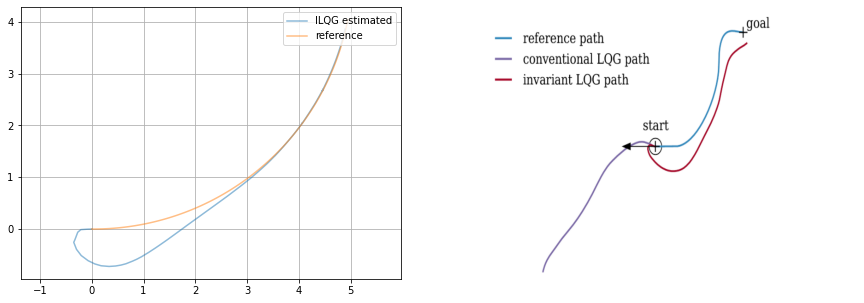

In [332]:
figure(figsize=(15,5))
subplot(121)
plot(xe[:, 0], xe[:, 1], label='ILQG estimated', alpha=0.5)
plot(xr[:, 0], xr[:, 1], label = 'reference', alpha=0.5)
legend(loc=1)
grid()
axis('equal');
subplot(122)
imshow(imread('./images/lqg.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

In [171]:
error

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.00547924, -0.02622703, -0.01232142],
       [ 0.00541872, -0.02690048, -0.01223174],
       [ 0.0054102 , -0.02776198, -0.0122335 ],
       [ 0.00539894, -0.02861818, -0.01223316],
       [ 0.0053889 , -0.02947442, -0.01223283],
       [ 0.00537691, -0.03033062, -0.0122325 ],
       [ 0.00536619, -0.03118679, -0.01223215],
       [ 0.00535553, -0.03204295, -0.0122318 ],
       [ 0.00534402, -0.03289908, -0.01223145],
       [ 0.00533391, -0.0337552 , -0.01223109],
       [ 0.00532351, -0.03461129, -0.01223073],
       [ 0.00531171, -0.03546734, -0.01223035],
       [ 0.00530122, -0.03632339, -0.01222998],
       [ 0.00529111, -0.03717941, -0.0122296 ],
       [ 0.00528019, -0.03803539, -0.01222922],
       [ 0.00527008, -0.03889135, -0.01222882],
       [ 0.00526009, -0.0397473 , -0.01222843],
       [ 0.00524723, -0.04060317, -0.01222801],
       [ 0.00523586, -0.04145902, -0.01222759],
       [ 0.00522468, -0.04231486, -0.012